# Configs and Imports

In [1]:
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    Trainer, 
    TrainingArguments, 
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    set_seed
)
from tokenizers import AddedToken
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from datasets import Dataset, DatasetDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
import torch
import os
import random
import warnings
import wandb

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

2024-04-30 06:19:46.124890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 06:19:46.124992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 06:19:46.255598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED = 27

DEBERTA_V3_XSMALL   = 'microsoft/deberta-v3-xsmall'  # 22M
DEBERTA_V3_SMALL    = 'microsoft/deberta-v3-small'   # 44M
DEBERTA_V3_BASE     = 'microsoft/deberta-v3-base'    # 86M
DEBERTA_V3_LARGE    = 'microsoft/deberta-v3-large'   # 304M

MODEL_NAME = DEBERTA_V3_SMALL
MAX_TOKEN_LENGTH = 1024
LEARNING_RATE = 1e-5
MAX_EPOCHS = 100
BATCH_SIZE = 4
EVAL_STEPS = 100

In [3]:
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
set_seed(SEED)

In [4]:
use_wandb = True

if use_wandb:
    from kaggle_secrets import UserSecretsClient
    wandb_api_key = UserSecretsClient().get_secret("WANDB_API_KEY")
    os.environ["WANDB_PROJECT"] = "automated-essay-scoring"
    os.environ["WANDB_API_KEY"] = wandb_api_key
    run_name = f"{MODEL_NAME}-{MAX_TOKEN_LENGTH}-{BATCH_SIZE}-{LEARNING_RATE}"
    logger_config = {"report_to": "wandb", "run_name": run_name}
else:
    logger_config = {"report_to": "none"}

# Loading Data and Taking a Quick Look at the Text Lengths

In [5]:
train_df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')

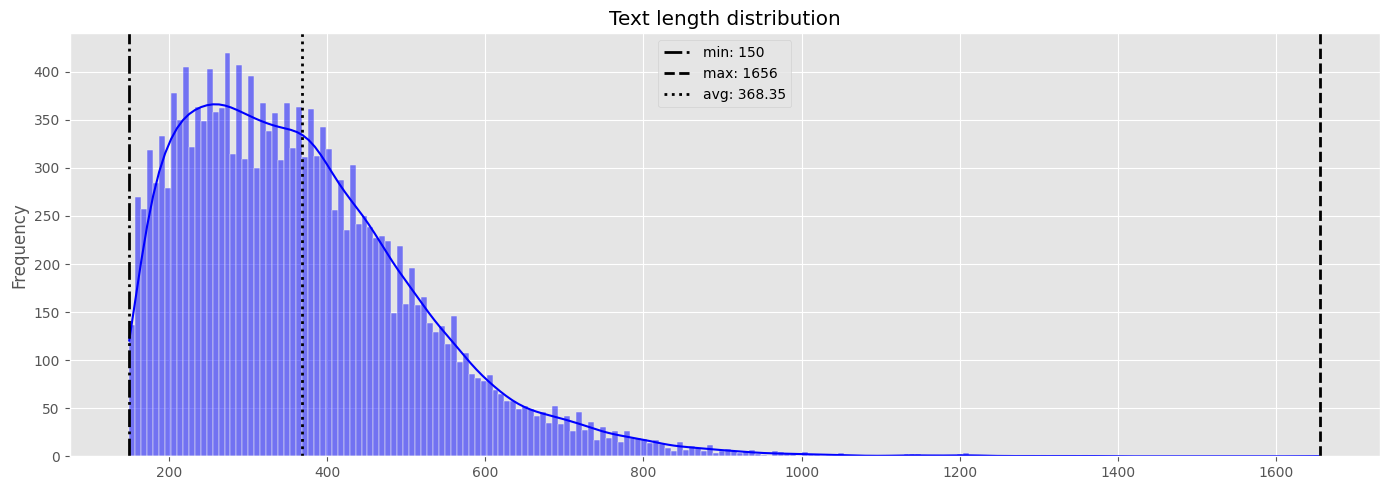

In [6]:
train_df["length"] = train_df["full_text"].apply(lambda x: len(x.split()))

train_avg_length = train_df.length.mean()
train_max_length = train_df.length.max()
train_min_length = train_df.length.min()

plt.figure(figsize=(14, 5))
sns.histplot(train_df.length.values, kde=True, color="blue", bins=200)
plt.axvline(train_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {train_min_length}')
plt.axvline(train_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {train_max_length}')
plt.axvline(train_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {train_avg_length:.2f}')
plt.title("Text length distribution")
plt.ylabel("Frequency")
plt.legend(loc='best')

plt.tight_layout()
plt.show()

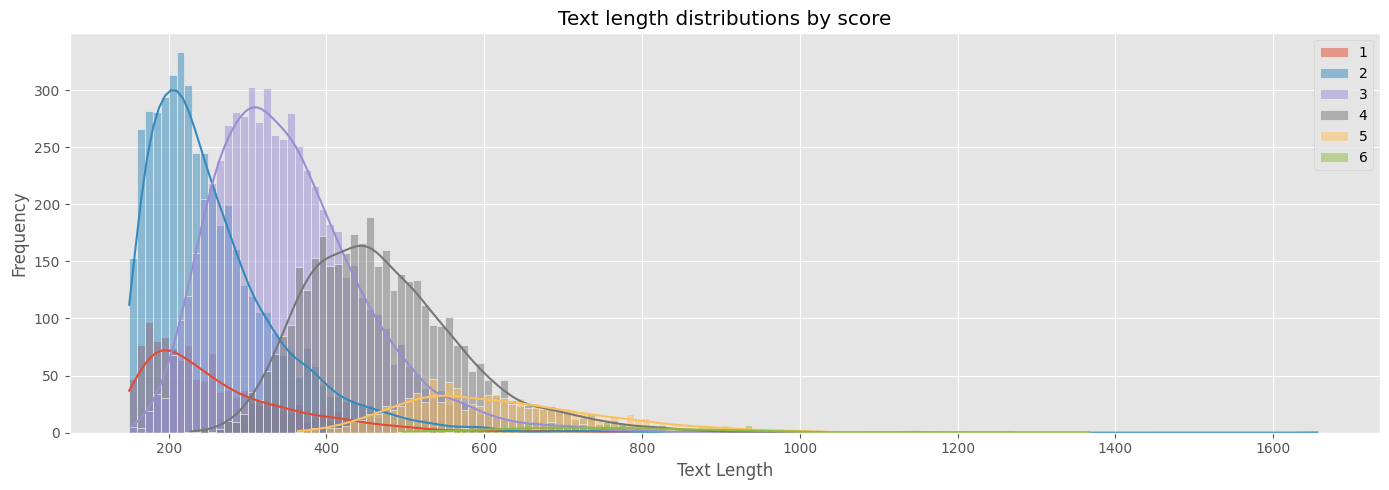

In [7]:
bin_width = 10
bins = range(
    train_df.length.min(),
    train_df.length.max() + bin_width, 
    bin_width
)

plt.figure(figsize=(14, 5))
for label, df in train_df.groupby("score"):
    sns.histplot(df.length.values, kde=True, bins=bins, label=label, alpha=0.5)
plt.title("Text length distributions by score")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Splitting The Dataset Into Train and Validation Sets

In [8]:
train_df["label"] = train_df["score"].apply(lambda x: x - 1)

# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
# for i, (_, val_index) in enumerate(skf.split(train_df, train_df["score"])):
#     train_df.loc[val_index, "fold"] = i

In [9]:
train_ds = train_df.sample(frac=0.9, random_state=42)
val_ds = train_df.drop(train_ds.index)

del train_df

In [10]:
train_ds = Dataset.from_pandas(train_ds)
val_ds = Dataset.from_pandas(val_ds)
dataset = DatasetDict({
    'train': train_ds,
    'val': val_ds
})

# Tokenizing

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])

def tokenize(sample):
    return tokenizer(
        sample['full_text'],
        max_length=MAX_TOKEN_LENGTH,
        truncation=True
    )

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [12]:
dataset = dataset.map(tokenize, batched=True).remove_columns(['length', 'essay_id', 'full_text', 'score','__index_level_0__'])

Map:   0%|          | 0/15576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15576
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1731
    })
})

# Defining Training Metrics and Arguments

In [14]:
def compute_metrics(preds):
    predictions, labels = preds
    score = cohen_kappa_score(
        y1=labels,
        y2=predictions.argmax(-1),
        weights='quadratic'
    )
    return {'qwk': score}

In [15]:
training_args = TrainingArguments(
    num_train_epochs=MAX_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type='linear',
    output_dir=f'/kaggle/working/{MODEL_NAME}', 
    do_eval=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    load_best_model_at_end=True,
    save_total_limit=1,
    seed=SEED,
    data_seed=SEED,
#     fp16=True,
    metric_for_best_model="qwk",
    greater_is_better=True,
    **logger_config
)

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=6)
model.resize_token_embeddings(len(tokenizer))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer), 
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

In [17]:
trainer.train()
trainer.evaluate()

wandb: Currently logged in as: ravaghi. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240430_062024-iiffy3cr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run microsoft/deberta-v3-small-1024-4-1e-05
wandb: ⭐️ View project at https://wandb.ai/ravaghi/automated-essay-scoring
wandb: 🚀 View run at https://wandb.ai/ravaghi/automated-essay-scoring/runs/iiffy3cr


Step,Training Loss,Validation Loss,Qwk
100,1.487300,1.224499,0.416594
200,1.143300,1.058231,0.652739
300,1.073700,1.075529,0.670240
400,1.030500,0.930874,0.740353
500,0.945200,0.943734,0.723926
600,0.949400,0.988774,0.705737
700,0.968600,0.926321,0.743415
800,0.896000,0.935977,0.739613
900,0.875700,0.961853,0.732522
1000,0.852600,1.071937,0.688544


{'eval_loss': 0.8399160504341125,
 'eval_qwk': 0.7690392755048483,
 'eval_runtime': 37.8687,
 'eval_samples_per_second': 45.711,
 'eval_steps_per_second': 11.434,
 'epoch': 1.64}

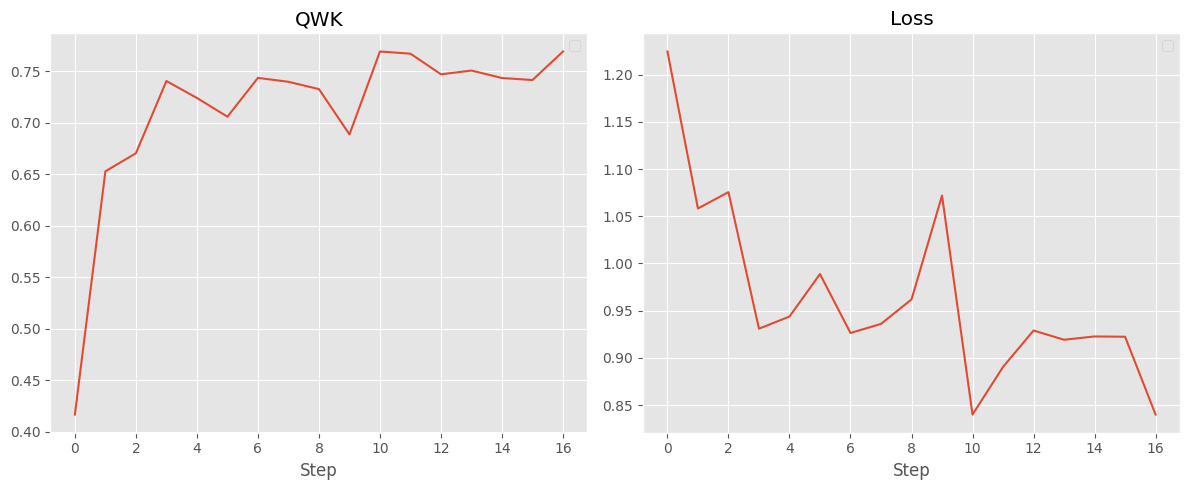

In [18]:
history = pd.DataFrame(trainer.state.log_history).dropna(subset=["eval_loss"]).set_index("step")
histories = {
    "QWK": history['eval_qwk'].values,
    "Loss": history['eval_loss'].values
}

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, metric in enumerate(["QWK", "Loss"]):
    ax[i].plot(histories[metric])
    ax[i].set_title(metric)
    ax[i].set_xlabel("Step")
    ax[i].legend()

plt.tight_layout()
plt.show()  

# Credits
This work is based on the following notebooks:
- https://www.kaggle.com/code/idv2005/deberta-baseline-train
- https://www.kaggle.com/code/idv2005/deberta-baseline-inference
- https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
- https://www.kaggle.com/code/hashidoyuto/deberta-5fold-infer-aes2-0?scriptVersionId=173129662

And the following discussion posts:
- https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/498571
- https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/497832